<a href="https://colab.research.google.com/github/caiogomide/imersao-dados-2021/blob/main/Notebooks/modelo_predicao_mecanismos_de_acao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Construção de um Modelo de Predição de Mecanismos de Ação Baseado em Assinaturas Celulares**

## **1. INTRODUÇÃO**


O objetivo deste projeto é construir um modelo de predição de **Mecanismos de Ação** com **acurácia de pelo menos x%** baseando-se nas informações disponiveis no *dataset* disponibilizado, informações estas como:
* Tempo de duração do tratamento;
* Dose(alta ou baixa); 
* Tipo de tratamento (tratado com composto ou uma pertubação de controle);    
* Identificação do composto; expressões gênicas e viabilidades celulares.


Para mais informações como o objetivo desta pesquisa, referências e metodologias aplicadas, leia o [projeto de pesquisa](https://github.com/caiogomide/imersao-dados-desafio-final/blob/main/Notebooks/imersao_dados_projeto_de_pesquisa.ipynb)


### **1.1 Glossário** 

**Base de Dados dos Experimentos:**

| Categoria | Significado |
| --- | --- |
| **id** | identificação única do experimento realizado |
| **tratamento** | tipo de tratamento realizado, se foi feito utilizando uma droga ou um composto de controle |
| **tempo** | tempo de duração do tratamento, em horas |
| **dose** | dose baixa ou dose alta (D1/D2) |
| **droga** | identificação do composto utilizado |
| **[g-0]->[g-771]** | expressão gênica, valores positivos indicam ação do composto no gene |
| **[c-0]->[c-99]** | viabilidade celular |

**Base de Dados dos Resultados dos Experimentos:**

| Categoria | Significado |
| --- | --- |
| **id** | identificação única do experimento realizado |
| **[5-alpha_reductase_inhibitor]->[wnt_inhibitor]** | 206 mecanismos de ação, 0 indica que não foi ativo, e 1 indica que foi ativo; |


## **2. EXPLORANDO OS DADOS DE EXPERIMENTOS** 

Para produzir um bom modelo de predição é imprescindível um bom conhecimento dos dados de experimentos, serão aqui analisados as distribuições de frequências e correlações destes dados.

### **2.1 Importação de Bibliotecas e Dados** 

In [265]:
# Importação biblitoecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
%matplotlib inline

In [266]:
# Importação de dados dos experimentos
url_dados = 'https://github.com/caiogomide/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true'
dados = pd.read_csv(url_dados, compression='zip')

### **2.2 Distribuição de Frequência dos Principais Dados de Experimento** 

#### 2.2.1 Tratamento

In [267]:
dist_freq_tratamento = pd.DataFrame()
#Obtenção da frequência absoluta dos tratamentos feitos com droga e com controle
dist_freq_tratamento['frequencia_absoluta'] = dados['tratamento'].value_counts()
#Obtenção da frequência relativa dos tratamentos feitos com droga e com controle
dist_freq_tratamento['frequencia_relativa'] = (dados['tratamento'].value_counts(normalize=True) * 100).map('{:.2f}%'.format)
#Nomeação do indice para tratamento
dist_freq_tratamento.index.rename('tratamento', inplace=True)
dist_freq_tratamento

,frequencia_absoluta,frequencia_relativa
tratamento,,
com_droga,21948,92.16%
com_controle,1866,7.84%



**Conclusão Parcial**: os estudos foram realizados majoritariamente com drogas (92.16%), há uma clara discrepância entre a frequência dos dois tipos de tratamento. Esta diferença deverá ser tomada em conta na criação do modelo de predição.


#### 2.2.2 Tempo

In [268]:
dist_freq_tempo = pd.DataFrame()
#Obtenção da frequência absoluta dos tratamentos feitos em 24, 48 e 72 horas
dist_freq_tempo['frequencia_absoluta'] = dados['tempo'].value_counts()
#Obtenção da frequência relativa dos tratamentos feitos em 24, 48 e 72 horas
dist_freq_tempo['frequencia_relativa'] = (dados['tempo'].value_counts(normalize=True) * 100).map('{:.2f}%'.format)
#Nomeação do indice para tempo
dist_freq_tempo.index.rename('tempo', inplace=True)
dist_freq_tempo

,frequencia_absoluta,frequencia_relativa
tempo,,
48,8250,34.64%
72,7792,32.72%
24,7772,32.64%


**Conclusão Parcial**: os resultados dos tratamentos foram analisados proporcionalmente 24, 48 e 72 horas após os experimentos, não foram observadas grandes discrepâncias, este dado não precisará ser tratado.


#### 2.2.3 Dose

In [269]:
dist_freq_dose = pd.DataFrame()
#Obtenção da frequência absoluta dos tratamentos feitos com dose D1 e D2
dist_freq_dose['frequencia_absoluta'] = dados['dose'].value_counts()
#Obtenção da frequência relativa dos tratamentos feitos com dose D1 e D2
dist_freq_dose['frequencia_relativa'] = (dados['dose'].value_counts(normalize=True) * 100).map('{:.2f}%'.format)
#Nomeação do indice para dose
dist_freq_dose.index.rename('dose', inplace=True)
dist_freq_dose

,frequencia_absoluta,frequencia_relativa
dose,,
D1,12147,51.01%
D2,11667,48.99%


**Conclusão Parcial**: Há uma proporcionalidade entre os tratamentos feitos com dose D1 e D2, não foram observadas grandes discrepâncias, este dado não precisará ser tratado.


#### 2.2.4 Droga

In [270]:
# Frequência de cada droga nos experimentos
quantidade_drogas = dados['droga'].value_counts()

In [271]:
# Criação de tabela de frequência de drogas
tabela_frequencia_drogas = pd.DataFrame(quantidade_drogas)
# Renomeação de coluna droga para frequência
tabela_frequencia_drogas.rename(columns={'droga':'frequencia'}, inplace=True)
# Renomeação de índice 
tabela_frequencia_drogas.index.rename('droga', inplace=True)
tabela_frequencia_drogas

,frequencia
droga,
cacb2b860,1866
87d714366,718
9f80f3f77,246
8b87a7a83,203
5628cb3ee,202
...,...
ed81f4046,1
a90e40334,1
37a8319f4,1


**Conclusão Parcial:** A droga cacb2b860 foi utilizada muita mais vezes do que as outras drogas, isso é devida a ela ser usada apenas para controle, este dado pode ser importante para a produção do modelo de predição de mecanismos de ação.

#### 2.2.5 Expressão Gênica [G-0] -> [G-771] 

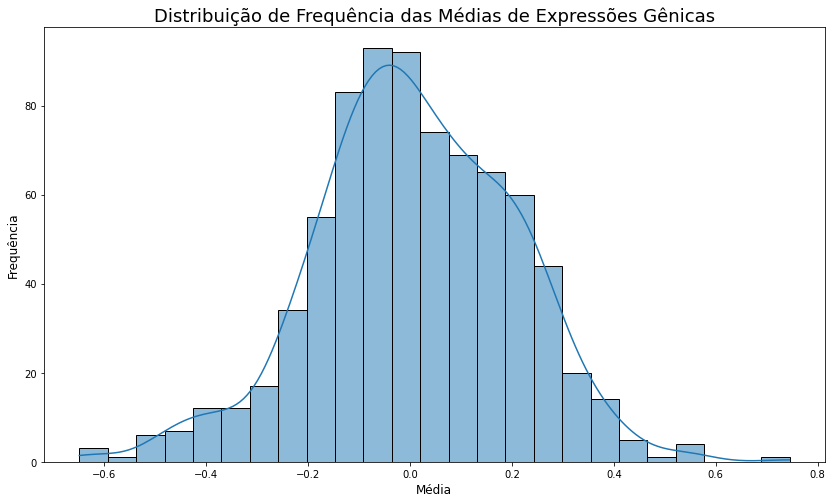

In [272]:
# Seleção de dados das expressoes genicas g0 até o g771
dados_expressoes_genicas = dados.loc[:,'g-0':'g-771']

# Medidas de tendencia central das expressões gênicas
info_dados_expressoes_genicas = dados_expressoes_genicas.describe().transpose()

# Configuração do tamanho do gráfico
plt.figure(figsize=(14,8))

# Distribuicao das médias de expressões gênicas
grafico_distribuicao_medias_ex_genicas = sns.histplot(info_dados_expressoes_genicas['mean'], kde=True)

# Configuração de titulo do gráfico
grafico_distribuicao_medias_ex_genicas.set_title('Distribuição de Frequência das Médias de Expressões Gênicas', fontsize=18)

# Configuração da legenda do eixo x
grafico_distribuicao_medias_ex_genicas.set_xlabel('Média', fontsize=12)

# Configuração da legenda do eixo y
grafico_distribuicao_medias_ex_genicas.set_ylabel('Frequência', fontsize=12)

# Mostrando gráfico
plt.show()

**Conclusão Parcial:** em média, as médias das expressões gẽnicas se comportam como uma curva normal, a maior parte dos valores estão concentrados entre -0.2 e +0.2, vale lembrar que para o objeto de estudo, a criação do modelo de predição, os dados outliers, que apresentam em uma distribuição entre 0.6 e 0.8 são as mais interessantes 

2.2.6 Viabilidade Celular [C-0]->[C-99]

In [273]:
dados

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397

### **2.3 Correlação Entre os Dados de Experimentos**
Será investigado se há correlação entre os dados de experimentos secundários e a expressão gênica zero

#### 2.3.1 Formatação dos Dados de Tratamento para Booleano

In [274]:
# Transformação de colunas tratamento e tempo em booleano
dados = pd.get_dummies(dados, columns=['tratamento', 'tempo'])

#### 2.3.2 Tratamento com Controle x Expressão Gênica 

In [275]:
correlacao_dados = dados.corr()

In [276]:
# Cálculo de correlacao entre expressão genica g0 e tratamento com controle
correlacao_g_0_com_controle = correlacao_dados['g-0']['tratamento_com_controle']

**Conclusão Parcial:** é possível observar que a correlação entre tratamento com controle e expressão gênica é negativa, este dado era esperado pois os tratamentos com controle não devem influenciar na expressão gênica

## **3. CRIAÇÃO DE MODELO PREDIÇÃO DE MECANISMOS DE AÇÃO** 
Entendendo a estrutura dos dados e a organização, agora será criado um modelo de predição de mecanismo de ação

### **3.1 Merge das Tabelas**

In [277]:
#Cria uma series indicando quantos mecanismos foram ativados em cada experimento
ativacao_por_experimento = resultados.sum(axis=1, skipna=True)

#Cria uma coluna indicando o número de mecanismos ativados por um experimento 
resultados['mecanismos_ativados'] = ativacao_por_experimento

#Cria uma coluna indicando se o experimento em questão ativou algum mecanismo de ação ou não (True or False)
resultados['ativo'] = resultados['mecanismos_ativados'] != 0

# Merge de dados dos experimentos com os resultados, para isso foram selecionadas da coluna de resultados
# apenas os mecanismos ativados e se o determinado experimento foi ativo ou não, merge baseado no id dos experimentos
dados_com_resultados = pd.merge(dados, resultados[['id', 'mecanismos_ativados', 'ativo']],on='id')

### **3.2 Configuração do Modelo**

In [278]:
# Importação do modelo que será utilizado: Modelo de Classificacao de Vetor
from sklearn.svm import SVC

In [279]:
# Importação do método responsável por dividir dados de treino e teste 
from sklearn.model_selection import train_test_split

In [280]:
# Importação do método responsável por calcular acurácia dos modelos
from sklearn.metrics import accuracy_score

In [281]:
# Instanciação do modelo de classificação de vetor que será utilizado
modelo_classificacao_vetor = SVC()

In [282]:
# Determinacão das variáveis necessárias para criação do modelo de classificação de vetor

# Seleção de valores de expressão gênica e viabilidade celular para configuração de entrada (valores da assinatura celular)
x = dados_com_resultados.select_dtypes('float64')
# Seleção dos valores da coluna ativa para configuração de saída (valores que serão previstos)
y = dados_com_resultados['ativo']

In [283]:
# Divisão entre dados de treino e teste para as variáveis x e y
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, stratify=y, random_state=404)

### **3.3 Treinamento e Análise do Modelo**

In [284]:
# Treinamento do modelo de classificação de vetor, utilizando valores de entrada e saída
# A função do modelo é receber os valores da assinatura celular(x) e prever se esta assinatura irá ativar algum mecanismo de ação(y) ou não
modelo_classificacao_vetor.fit(x_treino, y_treino)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [285]:
# Previsão do modelo de regressão logística
previsao_modelo_classificacao_vetor = modelo_regressao_logistica.predict(x_teste)

In [288]:
# Calculo de acurácia do modelo de regressão logística
accuracy_score(y_teste, previsao_modelo_classificacao_vetor)

0.9951711106445518

## **4. CONCLUSÃO**


**Objetivo Inicial**: 90% de acuracidade;

**Resultado**: 99.51% de acuracidade;

O objetivo da pesquisa foi alcançado e superado, o modelo de predição está satisfatório para o modelo apresentado.
